# Classification of Wine Reviews

This project explores a data set consisting of 130,000 text-based wine reviews. Our goal is to classify a wine as "above average" or "below average" based on its text review. To that end, we will select and create a few features of the text. Then, we will use these features to train the Naive Bayes algorithm.

This data has been sourced from Kaggle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import PorterStemmer
from textblob import TextBlob
from textblob import Word
import re
warnings.filterwarnings('ignore')
%matplotlib inline
wine = pd.read_csv('wine.csv')
wine = wine.drop(columns='Unnamed: 0')

## Data Exploration

In this section, we explore some of the data.

First, we will examine the ten most reviewed countries (with the respective number of reviews).

In [2]:
countries=wine.groupby(['country']).count().reset_index()
countries=countries.sort_values('description', ascending=False)
countries=countries[['country', 'description']]
countries.reset_index(drop=True, inplace=True)
countries.head(10)

,country,description
0,US,54504
1,France,22093
2,Italy,19540
3,Spain,6645
4,Portugal,5691
5,Chile,4472
6,Argentina,3800
7,Austria,3345
8,Australia,2329
9,Germany,2165


Next, we observe the ten most common varieties (with respective number of reviews).

In [3]:
varieties=wine.groupby(['variety']).count().reset_index()
varieties=varieties.sort_values('description', ascending=False)
varieties=varieties[['variety', 'description']]
varieties.reset_index(drop=True, inplace=True)
varieties.head(10)

,variety,description
0,Pinot Noir,13272
1,Chardonnay,11753
2,Cabernet Sauvignon,9472
3,Red Blend,8946
4,Bordeaux-style Red Blend,6915
5,Riesling,5189
6,Sauvignon Blanc,4967
7,Syrah,4142
8,Rosé,3564
9,Merlot,3102


We are also interested in the distribution of the ratings.

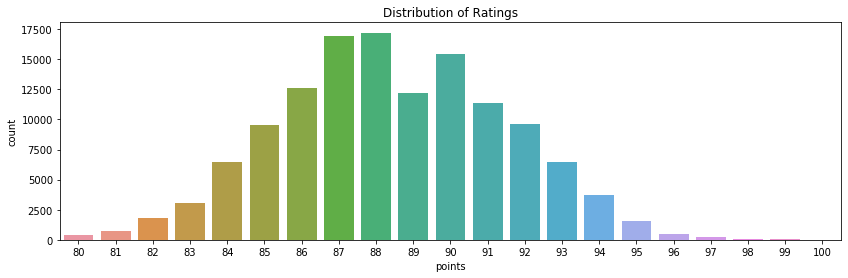

In [4]:
plt.figure(figsize=(14,4))
sns.countplot(x='points', data=wine).set_title("Distribution of Ratings")
plt.show()

Although the data consists of several reviews, there are only a handful of critics. Here, we provide the names of critics, together with the number of reviews and the average score for each critic.

In [5]:
critic=pd.DataFrame(wine.groupby(['taster_name', 'points'], as_index=False).mean().groupby('taster_name')['points'].mean())
critic.rename(columns={'points':'average points'}, inplace=True)
taster=wine.groupby(['taster_name']).count().reset_index()
taster=taster.sort_values('taster_name', ascending=True)
taster=taster[['taster_name', 'description']]
taster.rename(columns={'description':'number of reviews'}, inplace=True)
taster.rename(columns={'taster_name':'name of critic'}, inplace=True)
avg_n_critic=pd.concat([critic.reset_index(drop=1), taster.reset_index(drop=1).add_suffix('_2')], axis=1).fillna('')
avg_n_critic.rename(columns={'taster_name_2':'name'}, inplace=True)
avg_n_critic.rename(columns={'number of reviews_2':'number of reviews'}, inplace=True)
avg_n_critic.rename(columns={'name of critic_2':'name of critic'}, inplace=True)
columns_titles = ["name of critic","number of reviews", "average points"]
avg_n_critic=avg_n_critic.reindex(columns=columns_titles)
avg_n_critic['average points']=avg_n_critic['average points'].round(decimals=2)
avg_n_critic.head(20)

,name of critic,number of reviews,average points
0,Alexander Peartree,415,85.50
1,Anna Lee C. Iijima,4415,89.00
2,Anne Krebiehl MW,3685,88.94
3,Carrie Dykes,139,86.09
4,Christina Pickard,6,87.75
5,Fiona Adams,27,86.86
6,Jeff Jenssen,491,89.50
7,Jim Gordon,4177,88.50
8,Joe Czerwinski,5147,90.00
9,Kerin O’Keefe,10776,90.00


Is there a relationship between the number of reviews & the average score?

Text(0.5, 1.0, 'Number of Reviews & Average Score')

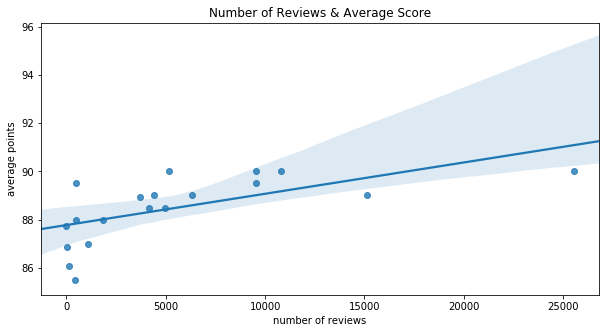

In [6]:
plt.figure(figsize=(10,5))
sns.regplot(x="number of reviews", y="average points", data=avg_n_critic).set_title("Number of Reviews & Average Score")

There appears to be a moderate positive correlation. It appears that there is a lot of variance for those who do not review that many wines. We verify the correlation coefficient below.

In [34]:
from scipy.stats import pearsonr
corr, _ = pearsonr(avg_n_critic['average points'], avg_n_critic['number of reviews'])
print(corr)

0.6254155732838154


We also observe some general statistics about the points awarded for each wine.

In [7]:
#Average rating, and other statistics for the points awarded for each wine
wine['points'].describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

The average score is 88.45, with a range of 80 and 100 points.

## Pre-processing of Data

In this section, we clean the text of the reviews, e.g. removing stop words, puncutation, and numerical values.

In [8]:
wine['description'] =wine['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
wine['description'] = wine['description'].str.replace('[^\w\s]','')
stop = stopwords.words('english')
wine['description'] = wine['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
freq = pd.Series(' '.join(wine['description']).split()).value_counts()[:10]
freq = list(freq.index)
wine['description'] = wine['description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
freq = pd.Series(' '.join(wine['description']).split()).value_counts()[-10:]
freq = list(freq.index)
wine['description'] = wine['description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
st = PorterStemmer()
wine['description'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
wine['description'] = wine['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
wine['description']= wine['description'].str.replace('\d+', '')

## Feature Selection and Creation

Now that we have processed the text of the reviews, we will create some features related to the text. 

The first feature that we are interested in is the word count of the review. We believe that the length of the review relates to the quality of the wine, as a critic may not be inclined to write a lengthy negative review.

From there, we will classify wines as "above average" if the score is above 88, and separate the data accordingly. We will study the 1-grams of these two groups.

In [9]:
#Word count of the review
wine['count'] = wine['description'].str.count(' ') + 1

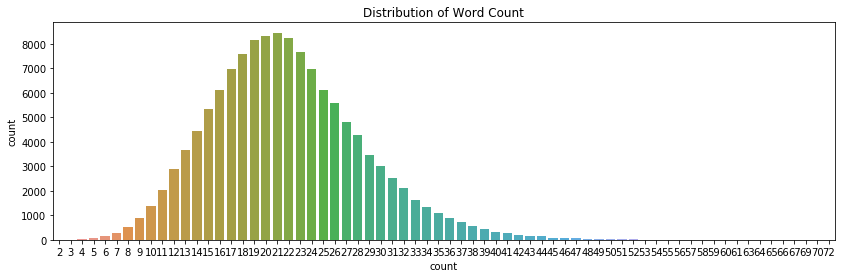

In [10]:
#Distribution of word counts
plt.figure(figsize=(14,4))
sns.countplot(x='count', data=wine).set_title("Distribution of Word Count")
plt.show()

In [11]:
wine['count'].describe()

count    129971.000000
mean         21.780720
std           6.628436
min           2.000000
25%          17.000000
50%          21.000000
75%          26.000000
max          72.000000
Name: count, dtype: float64

On average, there are approximately 22 words in a given review, after removing stop words and numerical values.

The data has a strong peak in the center, which we verify by calculating the kurtosis.

In [12]:
from scipy.stats import kurtosis
kurtosis(wine['count'], axis=0, fisher=True, bias=True)

0.9085559605173477

Using the mean value of 88.45 as a benchmark, we will introduce the parameter for classification. If a wine has a score greater than 88, it is considered "above average," and will be assigned a 1 in the data frame. Otherwise, the wine is assigned a 0. Since the wines only have integer-valued scores, we do not have to worry about the precision of our split.

In [13]:
#Add "above average" feature based on the mean score of 88
def g(wine):
    if wine['points'] > 88:
        val = 1
    else:
        val = 0
    return val
wine['above_avg'] = wine.apply(g, axis=1)

At this point, we will split the data into two smaller sets depending on the value in the "above average" column. Our goal is to study the 1-grams of each data set. Are there common words for really good wines? What about mediocre wines? Are there common words for all wines? 

The use of 1-grams will allow us to visualize any possible discrepancies between the two classes of wines. We highlight one limitation in the removal of stop words: "not" is considered a stop word, and it is possible that some less-than-positive reviews use "not." 

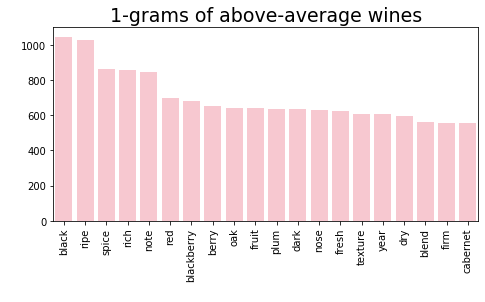

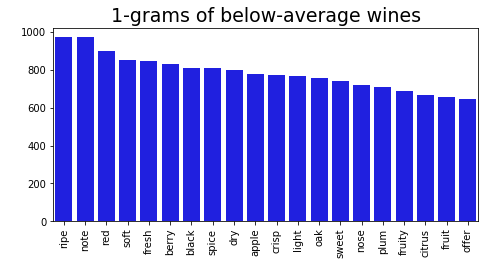

In [14]:
#Study 1-grams

import matplotlib.gridspec as gridspec

wine_top=wine[wine['above_avg']==1]
wine_low=wine[wine['above_avg']==0]

grid = gridspec.GridSpec(5, 2)
plt.figure(figsize=(16,7*4))

for n, cat in enumerate(wine_top['variety'].index[:1]):
    
    ax = plt.subplot(grid[n])   
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df=5, 
                                 stop_words='english',
                                 max_df=.5) 
    
    X2 = vectorizer.fit_transform(wine_top['description']) 
    features = (vectorizer.get_feature_names()) 
    scores = (X2.toarray()) 
    
    # Getting top ranking features 
    sums = X2.sum(axis = 0) 
    data1 = [] 
    
    for col, term in enumerate(features): 
        data1.append( (term, sums[0,col] )) 

    ranking = pd.DataFrame(data1, columns = ['term','rank']) 
    words = (ranking.sort_values('rank', ascending = False))[:60]
    words_graph = (ranking.sort_values('rank', ascending = False))[:20]

    sns.barplot(x='term', y='rank', data=words_graph, ax=ax, 
                color='pink', orient='v')
    ax.set_title("1-grams of above-average wines", fontsize=19)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_ylabel(' ')
    ax.set_xlabel(" ")

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.1)

plt.show()

#Study n-grams

grid = gridspec.GridSpec(5, 2)
plt.figure(figsize=(16,7*4))

for n, cat in enumerate(wine_low['variety'].index[:1]):
    
    ax = plt.subplot(grid[n])   
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df=5, 
                                 stop_words='english',
                                 max_df=.5) 
    
    X2 = vectorizer.fit_transform(wine_low['description']) 
    features = (vectorizer.get_feature_names()) 
    scores = (X2.toarray()) 
    
    # Getting top ranking features 
    sums = X2.sum(axis = 0) 
    data1 = [] 
    
    for col, term in enumerate(features): 
        data1.append( (term, sums[0,col] )) 

    ranking = pd.DataFrame(data1, columns = ['term','rank']) 
    words_2 = (ranking.sort_values('rank', ascending = False))[:60]
    words_2_graph = (ranking.sort_values('rank', ascending = False))[:20]

    sns.barplot(x='term', y='rank', data=words_2_graph, ax=ax, 
                color='blue', orient='v')
    ax.set_title("1-grams of below-average wines", fontsize=19)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_ylabel(' ')
    ax.set_xlabel(" ")

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.1)

plt.show()

We see that some of the 1-grams appear in both data sets, e.g. "ripe." We take the symmetric difference of the 1-grams to truly distinguish those of the above-average wines from those of the below-average wines. From there, we add another feature to the data set. If a wine review contains one of of the "top traits," it receives a "True"  in that column of the data set. Similarly, if a wine review contains one of the "bottom traits," it receives a "True" in that column of the data set. 

Note that it is possible that some reviews may not contain any of the top traits nor any of the bottom ones, as the 1-grams do not exhaust all of the reviews. Therefore, there may be some wines that have a "False" in both of these columns. We also note that some below-average wines contain some of the top traits simply because those top traits do not appear as 1-grams of below-average wines. We will address this obstruction shortly.

Finally, the graphs above picture the top twenty 1-grams, but our stored list consists of the top sixty 1-grams. This will be useful for building a more robust feature.

In [15]:
#Create two lists of top grams
#Find symmetric difference
set1=set(words['term'][0:60])
set2=set(words_2['term'][0:60]) 

top_traits=list(set1-set2)

bottom_traits=list(set2-set1)

print(top_traits)

print(bottom_traits)

['aging', 'delicious', 'wood', 'structured', 'structure', 'fine', 'complex', 'balance', 'year', 'mineral', 'age', 'dense', 'firm', 'vineyard', 'balanced', 'chocolate', 'long', 'concentrated']
['open', 'flavor', 'feel', 'bit', 'tannic', 'herbal', 'simple', 'pinot', 'slightly', 'clean', 'taste', 'tart', 'ready', 'sauvignon', 'like', 'spicy', 'fruity', 'green']


By taking the symmetric difference, we see, for example, that above-average wines tend to be complex and delicious, while below-average wines tend to be simple and tart. As the last step of this feature creation, we record the appearances of these words in the data frame.

In [16]:
#Top and bottom traits feature
tt_pattern = '|'.join(top_traits)

wine['top traits']=wine.description.str.contains(tt_pattern).to_frame()

bt_pattern = '|'.join(bottom_traits)

wine['bottom traits']=wine.description.str.contains(bt_pattern).to_frame()

We now examine the aforementioned issue about top traits appearing in below-average wines. For example, "firm" is not a 1-gram for below-average wines, but some below-average wines contain the word "firm" in their description. We will visualize the prevalence of this obstruction. 

Text(0.5, 1.0, 'Below-average Wines with Top Traits')

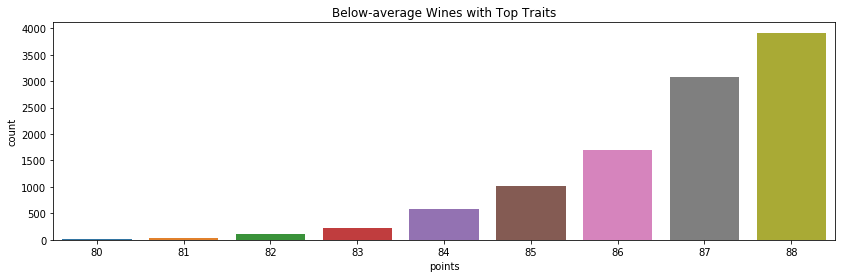

In [17]:
wine_top=wine[wine['above_avg']==1]
wine_low=wine[wine['above_avg']==0]
traits_wine=wine[wine['bottom traits']==False]
traits_wine=traits_wine[traits_wine['top traits']==True]
traits_wine=traits_wine[traits_wine['points']<89]

#Distribution of below-average wines with top traits
plt.figure(figsize=(14,4))
sns.countplot(x='points', data=traits_wine).set_title("Below-average Wines with Top Traits")

A similar situtation occurs in the collection of above-average wines. We provide visual evidence for this.

Text(0.5, 1.0, 'Above-average Wines with Bottom Traits')

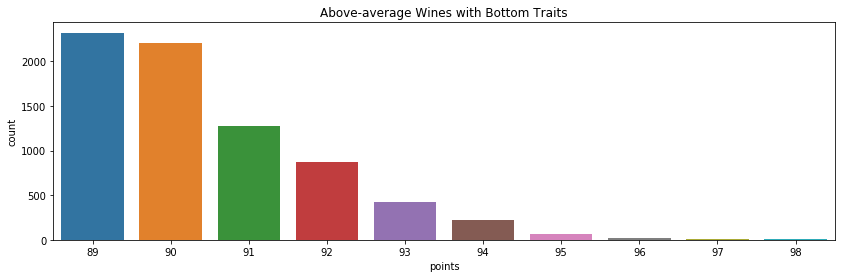

In [18]:
other_wine=wine[wine['bottom traits']==True]
other_wine=other_wine[other_wine['top traits']==False]
other_wine=other_wine[other_wine['points']>88]

#Distribution of below-average wines with top traits
plt.figure(figsize=(14,4))
sns.countplot(x='points', data=other_wine).set_title("Above-average Wines with Bottom Traits")

In practice, the majority of "misrepresented" wines per the 1-gram traits are those clustered around the mean. We add more one nuance to this feature. Rather than a binary classification of top versus bottom traits, we can count the occurrences of each trait within a given review. In particular, we add two new columns to the data frame: a count of the top traits, and a count of the bottom traits, in order to take into account that some wines may have both. 

In [25]:
def create_occurences(df):
    top_traits_list = []
    bottom_traits_list = []
    for text in df['description']:
        top_traits_words = 0
        bottom_traits_words = 0
        for word in text.split(' '):
            if word in top_traits:
                top_traits_words += 1
            elif word in bottom_traits:
                bottom_traits_words += 1
        top_traits_list.append(top_traits_words)
        bottom_traits_list.append(bottom_traits_words)
    df['top_traits_words'] = pd.Series(top_traits_list, index=df.index)
    df['bottom_traits_words'] = pd.Series(bottom_traits_list, index=df.index)

create_occurences(wine)

## Naive Bayes Algorithm

We will split the data into training and testing sets. We choose the (Gaussian) Naive Bayes algorithm as it is quite popular for text classification. We train with the features from the previous section: the word count, the top traits, and the bottom traits. Using this algorithm, our goal is to use these features to classify a wine as "above average" or not. 

In [20]:
#Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(wine, test_size=0.5, random_state=0)

Here, we will use the binary feature of top or bottom traits.

In [28]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
gnb = GaussianNB()
used_features = ["count", "top traits", "bottom traits"]
# Train classifier
gnb.fit(
    X_train[used_features].values,
    X_train['above_avg']
)
y_pred = gnb.predict(X_test[used_features])

# Print results
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (X_test['above_avg'] != y_pred).sum(),
          100*(1-(X_test['above_avg'] != y_pred).sum()/X_test.shape[0])
))

Number of mislabeled points out of a total 64986 points : 18841, performance 71.01%


Here, we will use the counts of the top and bottom traits.

In [29]:
used_features_2 = ["count", "top_traits_words", "bottom_traits_words"]
x=wine[used_features_2].values
y=wine['above_avg']
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.5, random_state=0)
model= GaussianNB()
model.fit(x_train, y_train)
y_pred=model.predict(x_test)
y_pred
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test, y_pred)*100
accuracy

72.27556704520973

There is some improvement, though not a significant one. 

Finally, we include the confusion matrix.

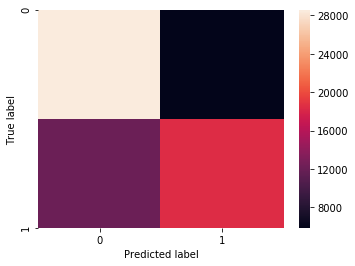

In [30]:
#Add confusion matrix.
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Concluding Thoughts

Naive Bayes appears to be a decent algorithm for text classification. There is room for improvement, possibly by adding more features or replacing some of the previous features with different ones. 

### Other features?
Are n-grams of particular value? Though the analysis was not included, the answer turned out to be "not really." In particular, we also explored the 2-grams of the separated data sets. However, when we added this feature to the algorithm, there was no noticeable improvement. The 2-grams are not frequent enough in the way that the 1-grams were.

One potential feature is to cluster the wines whose centroids consist of words (in terms of sentiment, or more related to wine technicalities). For example, "complex" wines tend to fare better, but complexity in terms of wine is multifaceted. At the moment, we do not know a metric that would be reasonable to implement for this kind of feature. We could possibly try and build a graph that connects "complex" to other descriptors of above-average wines.

Finally, we could possibly expand on our lists for top and bottom traits. One possibility is to split up the data into quartiles and perform an n-gram analysis on those quartiles to perhaps find more nuanced lists, and build top and bottom traits from a combination of the top two and bottom two quartiles, respectively.

### Other algorithms?
This project is ongoing. Some alternative algorithms (of potential higher accuracy) include random forests and decision trees. 